# Pattern Recognition-Coursework1

https://github.com/Yakun-Liu/Pattern-Recognition-cw1 for codes

Written by Yakun Liu     
Department of Electrical and Electronic Engineering    
Imperial College London

In [2]:
import os
import sys
import time
import math
import psutil
import mat4py
import random
import itertools
import numpy as np
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score,mean_squared_error,confusion_matrix
from sklearn.model_selection import StratifiedKFold,StratifiedShuffleSplit
from memory_profiler import memory_usage
skf = StratifiedKFold(n_splits=5)

Functions

In [4]:
#Confusion matrix
def plot_confusion_matrix(cm,title='Confusion matrix',cmap=plt.cm.Blues): 
    classes = []
    for i in range (1,53):
        classes.append(str(i))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes) 
    fmt =  'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

def PSNR(img1, img2):
    mse = np.mean( (img1/255. - img2/255.) ** 2 )
    #if mse < 1.0e-10:
    #return 100
    PIXEL_MAX = 1
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

# Nearest Neighbour classification
def NN_classification(x_train,x_test,label):
    dist = np.ones(x_train.shape[0])
    l = np.ones(x_test.shape[0])
    for i in range(0,x_test.shape[0]):
        for j in range(0,x_train.shape[0]):
            dist[j] = np.linalg.norm(x_train[j,:]-x_test[i,:])
        l[i] = label[np.argmin(dist)]
    return l

# normalisation
def normalise(g):
    g_min = np.min(g)
    g_max = np.max(g)
    for i in range(0,len(g)):
        g[i] = (g[i] - g_min)*255/(g_max-g_min)
    return g

#majority vote
def vote(x):
    y = np.zeros((x.shape[0],1))
    for i in range(len(y)):
        y[i] = np.argmax(np.bincount(x[i,:]))
    return y

# Q1. Computationally Efficient Eigenfaces

Load & Partition Data

In [5]:
data = mat4py.loadmat('face.mat')
X = np.array(data['X'] )#face sample
y = np.array(data['l']) #label
ss=StratifiedShuffleSplit(n_splits=1,test_size=0.2,train_size=0.8,random_state=2)

for train_index, test_index in ss.split(X.T, y):
    x_train, x_test = X.T[train_index], X.T[test_index]#训练集对应的值
    y_train, y_test = y[train_index], y[test_index]#类别集对应的值
print("image size:46*56 pixels")
print("number of images:",len(y))
print("number of training set images:",x_train.shape[1])
print("number of test set images:",x_test.shape[1])
print("number of classes:",len(set(y)))

image size:46*56 pixels
number of images: 520
number of training set images: 2576
number of test set images: 2576
number of classes: 52


Data Visualisation

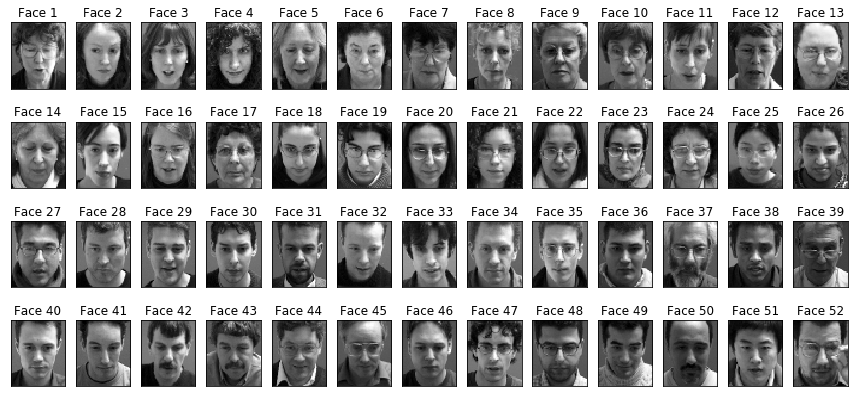

In [4]:
# Show all face images in dataset
plt.figure(figsize=(15,7))
for i in range(0,52):
    plt.subplot(4,13,i+1),plt.imshow(np.reshape(X[:,10*i],(46,56)).T, cmap = 'gist_gray')
    plt.title('Face '+str(i+1)), plt.xticks([]), plt.yticks([])

In [39]:
start = time.perf_counter()
x_tr_a = np.mean(x_train.T,1)
A = np.zeros((2576,416))
for i in range(0,416):
    A[:,i] = x_train.T[:,i]  - x_tr_a
S1 = 1/416*np.dot(A.T,A);  #low-dimensional PCA
a,b=np.linalg.eig(S1) #eigendecomposition
print(time.perf_counter() - start)

0.22973017499316484


Mean Image

(Text(0.5,1,'Mean Image'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

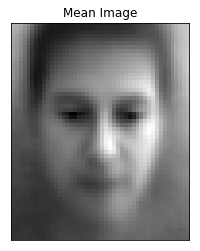

In [40]:
x_tr_a = np.mean(x_train.T,1)
plt.imshow(np.reshape(x_tr_a,(46,56)).T, cmap = 'gist_gray')
plt.title('Mean Image'),plt.xticks([]), plt.yticks([])

PCA vs Low-dimensional PCA

In [34]:
A = np.zeros((2576,416))
for i in range(0,416):
    A[:,i] = x_train.T[:,i]  - x_tr_a
# Covariance Matrix
S1 = 1/416*np.dot(A.T,A);  #low-dimensional PCA
S2 = 1/416*np.dot(A,A.T);  # original PCA

In [35]:
start = time.perf_counter()
a,b=np.linalg.eig(S1) #eigendecomposition
print(time.perf_counter() - start)
a = np.real(a)    #eigenvalues
b = np.real(b)    #eigenvectors

0.05974686499394011


In [36]:
print(b.shape)

(416, 416)


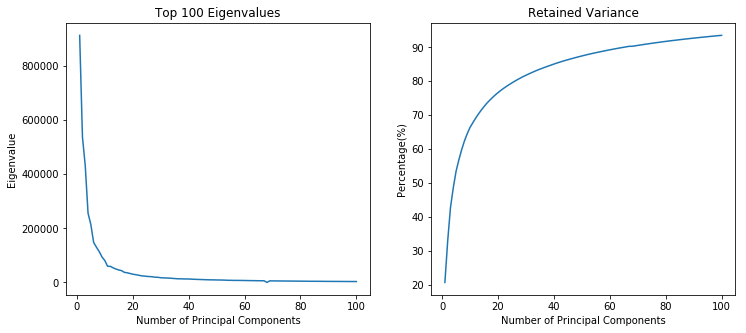

In [32]:
# Top 100 Eigenvalues
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1,101),a[:100])
plt.ylabel('Eigenvalue')
plt.xlabel('Number of Principal Components')
plt.title('Top 100 Eigenvalues')
# Retained Variance Percentage
e = np.zeros((100,1))
e_temp = 0
e_sum = sum(a)
for i in range(0,100):
    e_temp += a[i]
    e[i,0] = 100*e_temp/e_sum
plt.subplot(1,2,2)
plt.plot(range(1,101),e[:100])
plt.ylabel('Percentage(%)')
plt.xlabel('Number of Principal Components')
plt.title('Retained Variance')
plt.show()

Top 9 Eigenfaces

ValueError: cannot reshape array of size 416 into shape (46,56)

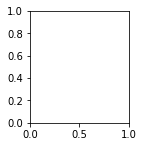

In [31]:
plt.figure(figsize=(6,7))
for i in range(0,9):
    plt.subplot(3,3,i+1),plt.imshow(np.reshape(normalise(b[:,i]),(46,56)).T, cmap = 'gist_gray')
    plt.title('Eigenface '+str(i+1)), plt.xticks([]), plt.yticks([])

Face Image in 3-dimentional eigen-subspace

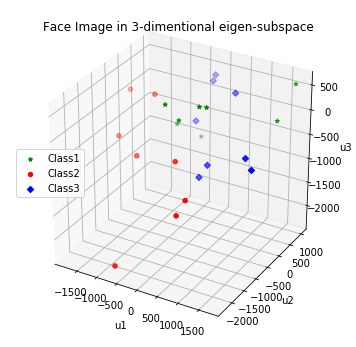

In [26]:
a1 = a[:3]
b1 = b[:,:3]
c = A@b1
norms = np.linalg.norm(c, axis=0) #normalisation of eigenvector
d = c/norms
w = d.T@A    #project onto eigen-subspace
plt.figure(figsize=(6,6))
ax = plt.subplot(111, projection='3d')  
ax.scatter(w[0,0:8], w[1,0:8], w[2,0:8], c='g',marker='*',label='Class1')   # 
ax.scatter(w[0,8:16], w[2,8:16], w[2,8:16],c= 'r',marker='o',label='Class2') #
ax.scatter(w[0,16:24], w[2,16:24], w[2,16:24], c='b',marker='D',label='Class3') #
ax.set_zlabel('u3')  # axis
ax.set_ylabel('u2')
ax.set_xlabel('u1')
plt.legend(loc='center left')
plt.title('Face Image in 3-dimentional eigen-subspace')
plt.show()

Face Reconstruction Using Eigenfaces

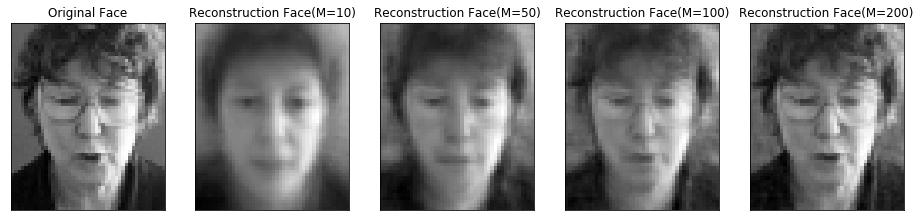

In [27]:
plt.figure(figsize=(16,4))
plt.subplot(1,5,1),plt.imshow(np.reshape(x_train[:,0],(46,56)).T, cmap = 'gist_gray')
plt.title('Original Face'), plt.xticks([]), plt.yticks([])
for i,M in enumerate([10,50,100,200]):
    a1 = a[:M]
    b1 = b[:,:M]
    c = A@b1
    norms = np.linalg.norm(c, axis=0) 
    d = c/norms
    w = d.T@A    #project onto eigen-subspace
    p = d@w     #reconstruction
    q = p[:,0] + x_tr_a
    plt.subplot(1,5,i+2),plt.imshow(np.reshape(q,(46,56)).T, 
                                    cmap = 'gist_gray')
    plt.title('Reconstruction Face(M='+str(M)+')'), 
    plt.xticks([]), plt.yticks([])

Quality of reconstructed faces

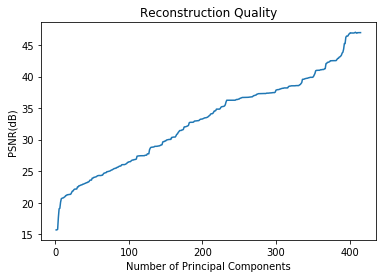

In [151]:
psnr = []
for M in range(1,416):
    a1 = a[:M]
    b1 = b[:,:M]
    c = A@b1
    norms = np.linalg.norm(c, axis=0) 
    d = c/norms
    w = d.T@A   #
    p = d@w 
    q = p[:,0] + x_tr_a 
    psnr.append(PSNR(x_train[:,0], q)) 
    
plt.plot(range(1,416),psnr)
plt.ylabel('PSNR(dB)')
plt.xlabel('Number of Principal Components')
plt.title('Reconstruction Quality')
plt.show()

Face Recongnition

In [36]:
M_pca = 415
x_scaler = StandardScaler()
x_n1 = x_scaler.fit_transform(x_train)
x_n2 = x_scaler.fit_transform(x_test)
pca = PCA(n_components=M_pca)
start = time.perf_counter()
pca.fit(x_n1)
time1 = time.perf_counter() - start
x_p1 = pca.transform(x_n1)   
x_p2 = pca.transform(x_n2) 
y_pre = NN_classification(x_p1,x_p2,y_train)
print('accuracy:',accuracy_score(y_test,y_pre))
print('time',time1)
acc1 = accuracy_score(y_test,y_pre)

D:\anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


accuracy: 0.7115384615384616
time 0.08505101699984152


Badcase

Failure cases: [1, 1, 2, 2, 11, 13, 15, 17, 17, 18, 19, 19, 20, 22, 23, 25, 28, 30, 33, 34, 35, 38, 41, 41, 42, 43, 43, 44, 44, 45, 48, 49, 51, 52, 52]
Faces who fails twice: [1, 2, 17, 19, 41, 43, 44, 52]


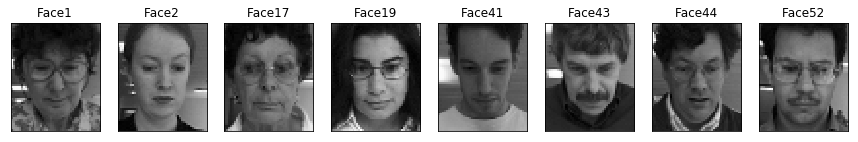

In [63]:
#all failure samples
badcase = [y_test[i] for i in range(len(y_test)) if y_test[i] != y_pre[i]] 
print('Failure cases:',badcase)
#samples which fail twice
badcase2 = [badcase[j] for j in range(len(badcase)-1) if badcase[j] == badcase[j+1]] 
print('Faces who fails twice:',badcase2)
plt.figure(figsize=(15,20))
for i in range(0,len(badcase2)):
    plt.subplot(1,len(badcase2),i+1)
    plt.imshow(np.reshape(normalise(x_test.T[:,badcase2[i]*2-1]),
        (46,56)).T, cmap = 'gist_gray')
    plt.title('Face'+str(badcase2[i])), plt.xticks([]), plt.yticks([])

<Figure size 720x720 with 0 Axes>

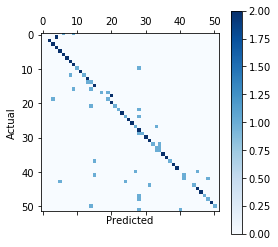

In [59]:
cm = confusion_matrix(y_test,y_pre)
plt.figure(figsize=(10,10))
#plot_confusion_matrix(cm)
plt.matshow(cm, cmap = 'Blues')
plt.colorbar()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

(array([146, 147, 148], dtype=int64),)


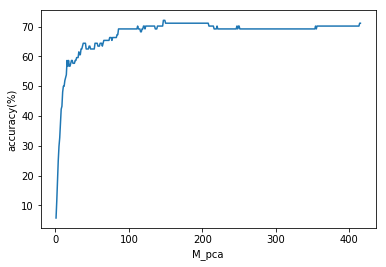

In [37]:
acc = np.zeros(415)
pca = PCA(n_components=415) 
pca.fit(x_n1)
x_p1 = pca.transform(x_n1)   # training 
x_p2 = pca.transform(x_n2)   #test
for i,M_pca in enumerate(range(1,416)):    
    y_pre = NN_classification(x_p1[:,:M_pca],x_p2[:,:M_pca],y_train) #test
    acc[i] =  accuracy_score(y_test,y_pre)*100
print(np.where(acc == np.max(acc)))    
plt.plot(range(1,416),acc)
plt.ylabel('accuracy(%)')
plt.xlabel('M_pca')
#plt.title('Accuracy')
plt.show()

# Q2. Incremental PCA

divide training set equally into 4 subsets

In [81]:
ss=StratifiedShuffleSplit(n_splits=1,test_size=0.75,train_size=0.25,random_state=2)
for train_index,test_index in ss.split(x_train, y_train):
    x_train1,x_test1 = x_train[train_index],x_train[test_index]
    y_train1,y_test1 = y_train[train_index],y_train[test_index]
ss=StratifiedShuffleSplit(n_splits=1,test_size=2/3,train_size=1/3,random_state=2)
for train_index,test_index in ss.split(x_test1, y_test1):
    x_train2,x_test2 = x_test1[train_index],x_test1[test_index]
    y_train2,y_test2 = y_test1[train_index],y_test1[test_index]
ss=StratifiedShuffleSplit(n_splits=1,test_size=0.5,train_size=0.5,random_state=2)
for train_index,test_index in ss.split(x_test2, y_test2):
    x_train3,x_train4 = x_test2[train_index],x_test2[test_index]
    y_train3,y_train4= y_test2[train_index],y_test2[test_index]

In [182]:
M_pca = 103
N1 = 104
N2 = 104
N3 = 104
N4 = 104
start = time.perf_counter()
x_a1 = np.mean(x_train1.T,1)
A1 = np.zeros((2576,104))
for i in range(0,104):
    A1[:,i] = x_train1.T[:,i]  - x_a1
S1 = 1/104*np.dot(A1,A1.T) 
s1 = 1/104*np.dot(A1.T,A1)
x_a2 = np.mean(x_train2.T,1)
A2 = np.zeros((2576,104))
for i in range(0,104):
    A2[:,i] = x_train2.T[:,i]  - x_a2
S2 = 1/104*np.dot(A2,A2.T)
s2 = 1/104*np.dot(A2.T,A2)
x_a3 = np.mean(x_train3.T,1)
A3 = np.zeros((2576,104))
for i in range(0,104):
    A3[:,i] = x_train3.T[:,i]  - x_a3
S3 = 1/104*np.dot(A3,A3.T)
s3 = 1/104*np.dot(A3.T,A3)
x_a4 = np.mean(x_train4.T,1)
A4 = np.zeros((2576,104))
for i in range(0,104):
    A4[:,i] = x_train4.T[:,i]  - x_a4
S4 = 1/104*np.dot(A4,A4.T) 
s4 = 1/104*np.dot(A4.T,A4)
a1,p1=np.linalg.eig(s1) 
a2,p2=np.linalg.eig(s2) 
a3,p3=np.linalg.eig(s3) 
a4,p4=np.linalg.eig(s4) 
P1 = np.dot(A1,p1[:,:M_pca])
P2 = np.dot(A2,p2[:,:M_pca])
P3 = np.dot(A3,p3[:,:M_pca])
P4 = np.dot(A4,p4[:,:M_pca])
print(time.perf_counter() - start)

0.28413303301203996


In [183]:
#update 1,2 to 5
N5 = N1 + N2
x_a5 = (N1*x_a1+N2*x_a2)/N5
S5 = 0.5*S1+0.5*S2+0.25*((x_a1-x_a2).reshape(2576,1)@(x_a1-x_a2).reshape(1,2576))
m1 = np.hstack((P1,P2,(x_a1-x_a2).reshape(len(x_a1),1)))
q1,r1 = np.linalg.qr(m1)
C1 = np.dot(np.dot(q1.T,S5),q1)
a5,p5 = np.linalg.eig(C1)
P5 = np.dot(m1,p5)

In [184]:
#update 5,3 to 6
N6 = N5 + N3
x_a6 = (N5*x_a5+N3*x_a3)/N6
S6 = N5/N6*S5+N3/N6*S3+(N5*N3/N6/N6)*((x_a5-x_a3).reshape(2576,1)@(x_a5-x_a3).reshape(1,2576))
m2 = np.hstack((P5,P3,(x_a5-x_a3).reshape(2576,1)))
q2,r2 = np.linalg.qr(m2)
C2 = np.dot(np.dot(q2.T,S6),q2)
a6,p6 = np.linalg.eig(C2)
P6 = np.dot(m2,p6)

In [185]:
#update 6,4 to 7
N7 = N6 + N4
x_a7 = (N6*x_a6+N4*x_a4)/N7
S7 = N6/N7*S6+N4/N7*S4+(N6*N4/N7/N7)*((x_a6-x_a4).reshape(2576,1)@(x_a5-x_a3).reshape(1,2576))
m3 = np.hstack((P6,P4,(x_a6-x_a4).reshape(2576,1)))
q3,r3 = np.linalg.qr(m3)
C3 = np.dot(np.dot(q3.T,S7),q3)
a7,p7 = np.linalg.eig(C3)
P7 = np.dot(m3,p7)

In [190]:
start = time.perf_counter()
a1,p1=np.linalg.eig(s1) 
a2,p2=np.linalg.eig(s2) 
a3,p3=np.linalg.eig(s3) 
a4,p4=np.linalg.eig(s4) 
a5,p5 = np.linalg.eig(C1)
a6,p6 = np.linalg.eig(C2)
a7,p7 = np.linalg.eig(C3)
print(time.perf_counter() - start)

0.11509071101318114


In [191]:
start = time.perf_counter()
a,b = np.linalg.eig(S1)
print(time.perf_counter() - start)

7.746856459008995


In [192]:
start = time.perf_counter()
a1,p1=np.linalg.eig(s1) 
print(time.perf_counter() - start)

0.004238382010953501


Implement IPCA

In [192]:
from sympy import *
L1 = []
L1.append(Matrix([1,2,3]))
L1.append(Matrix([2,1,3]))
L1.append(Matrix([3,2,1]))
L2 = [Matrix([1,2,3]), Matrix([2,1,3]), Matrix([3,2,1])]
o1 = GramSchmidt(L1,True)
print(o1[0])

Matrix([[sqrt(14)/14], [sqrt(14)/7], [3*sqrt(14)/14]])


In [124]:
print(L1)
print(L2)

[Matrix([
[1],
[2],
[3]]), Matrix([
[2],
[1],
[3]]), Matrix([
[3],
[2],
[1]])]
[Matrix([
[1],
[2],
[3]]), Matrix([
[2],
[1],
[3]]), Matrix([
[3],
[2],
[1]])]


In [119]:
L1 = []
for i in range(0,2):
    L1.append(Matrix([i*1,i*2,i*3]))

SyntaxError: unexpected EOF while parsing (<ipython-input-119-80b8c321447d>, line 3)

In [130]:
x_n1 = x_scaler.fit_transform(x_train)
x_n2 = x_scaler.fit_transform(x_test)
start = time.perf_counter()
ipca = IncrementalPCA(n_components=100, batch_size=104)
ipca.fit(x_n1)
time2 = time.perf_counter() - start
x_ipca1 = ipca.transform(x_n1) # training
x_ipca2 = ipca.transform(x_n2) # test
y_pre = NN_classification(x_ipca1,x_ipca2,y_train) # test
acc2 = accuracy_score(y_test,y_pre)
print('training time(s):',time2)
print('test set accuracy:',acc2)

D:\anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


training time(s): 0.12910023799850023
test set accuracy: 0.6826923076923077


PCA trained only by subset1

In [37]:
X_scaler = StandardScaler()
x_n1 = X_scaler.fit_transform(x_train1)
# PCA
start = time.perf_counter()
pca = PCA(n_components=415) 
pca.fit(x_n1)
time3 = time.perf_counter() - start
x_p1 = pca.transform(x_n1)   # training 
x_p2 = pca.transform(x_n2)   #test
#NN classification
y_pre = NN_classification(x_p1,x_p2,y_train1) #test
acc3 = accuracy_score(y_test,y_pre)

D:\anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [38]:
print('training time(s):',time3)
print('test set accuracy:',acc3)

training time(s): 0.020371042999613564
test set accuracy: 0.34615384615384615


Comparison: Batch PCA vs Incremental PCA vs PCA trained only by subset1

In [44]:
table = PrettyTable(["Algorithm", "Taining Time(s)","Recognition Accuracy(%)"])
table.add_row(["Batch PCA ",round(time1,4), round(acc1*100,2)])
table.add_row(["Incremental PCA",round(time2,4), round(acc2*100,2)])
table.add_row(["PCA on subset1",round(time3,4), round(acc3*100,2)])
table.align["Algorithm"] = "l"
print(table)

+-----------------+-----------------+-------------------------+
| Algorithm       | Taining Time(s) | Recognition Accuracy(%) |
+-----------------+-----------------+-------------------------+
| Batch PCA       |      0.0851     |          71.15          |
| Incremental PCA |      0.1535     |          68.27          |
| PCA on subset1  |      0.0204     |          34.62          |
+-----------------+-----------------+-------------------------+


# Q3. PCA-LDA Ensemble for Face Recognition

1.PCA-LDA

In [84]:
M_pca = 130
M_lda = 40
acc4 = 0
x_scaler = StandardScaler()
x_n1 = x_scaler.fit_transform(x_train)
x_n2 = x_scaler.fit_transform(x_test)
# PCA
pca = PCA(n_components = M_pca) 
pca.fit(x_n1)
x_p1 = pca.transform(x_n1)   # training 
x_p2 = pca.transform(x_n2)   #test
#LDA
lda = LDA(n_components = M_lda)
x_l1 = lda.fit_transform(x_p1, y_train)
x_l2 = lda.transform(x_p2)
    
#NN classification
y_pre = NN_classification(x_l1,x_l2,y_train) #test
acc4 = accuracy_score(y_test,y_pre)
print('test set accuracy:',acc4)

D:\anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
D:\anaconda\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


test set accuracy: 0.9711538461538461


Rank of Scatter Matrices

In [116]:
label = 52
s = 0
for label in range(1,53):
    m = np.mean(x_train[y_train==label],axis = 0)
    for i in range(x_train.shape[0]):
        if y_train[i] == label:
            s += np.dot(np.mat(x_train[i,:]-m).T,np.mat(x_train[i,:]-m))
print(s.shape)
print(np.linalg.matrix_rank(s))

(2576, 2576)
364


Failure cases: [47, 2, 33]


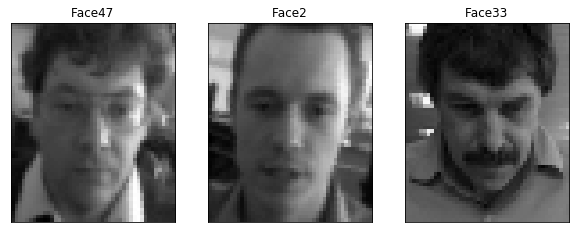

In [85]:
#all failure samples
badcase = [y_test[i] for i in range(len(y_test)) if y_test[i] != y_pre[i]] 
print('Failure cases:',badcase)

plt.figure(figsize=(10,15))
for i in range(0,len(badcase)):
    plt.subplot(1,len(badcase),i+1)
    plt.imshow(np.reshape(normalise(x_test.T[:,badcase[i]-1]),
                          (46,56)).T, cmap = 'gist_gray')
    plt.title('Face'+str(badcase[i])), plt.xticks([]), plt.yticks([])

<Figure size 720x720 with 0 Axes>

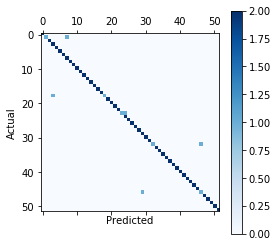

In [48]:
cm = confusion_matrix(y_test,y_pre)
plt.figure(figsize=(10,10))
#plot_confusion_matrix(cm)
plt.matshow(cm, cmap = 'Blues')
plt.colorbar()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Gridsearch

D:\anaconda\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
D:\anaconda\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


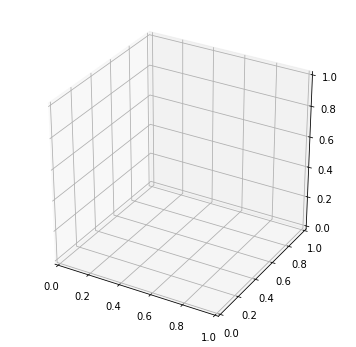

In [31]:
pca = PCA(n_components=415) 
pca.fit(x_n1)
x_p1 = pca.transform(x_n1)   
x_p2 = pca.transform(x_n2) 
x = range(1,416,10)
y = range(1,52,2)
acc = np.zeros((len(y),len(x)))
x, y = np.meshgrid(x, y)
for i,M_pca in enumerate(range(1,416,10)):
    for j,M_lda in enumerate(range(1,52,2)):
        lda = LDA(n_components= M_lda)
        x_l1 = lda.fit_transform(x_p1[:,:M_pca], y_train)
        x_l2 = lda.transform(x_p2[:,:M_pca])
        #NN classification
        y_pre = NN_classification(x_l1,x_l2,y_train) 
        acc[j,i] =  accuracy_score(y_test,y_pre)*100

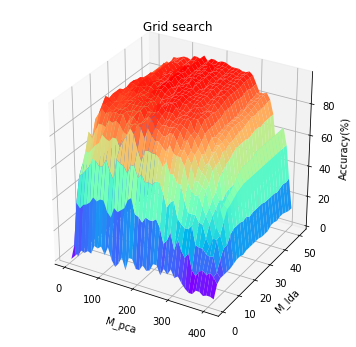

In [34]:
plt.figure(figsize=(6,6))
ax = plt.subplot(111, projection='3d') 
ax.plot_surface(x, y, acc, rstride = 1, cstride = 1,cmap=plt.get_cmap('rainbow'))    
#ax.contourf(x, y, acc, zdir='z', offset=-2,cmap=plt.get_cmap('rainbow'))    
ax.set_zlabel('Accuracy(%)') 
ax.set_ylabel('M_lda')
ax.set_xlabel('M_pca')
plt.title('Grid search')
plt.show()

find best Mpca

D:\anaconda\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
D:\anaconda\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(array([130], dtype=int64),)


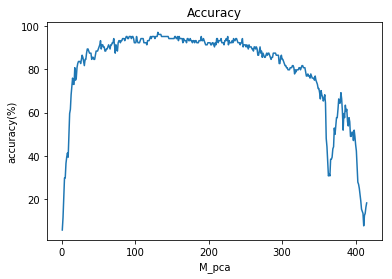

In [79]:
M_lda = 40
acc = np.zeros(415)
pca = PCA(n_components=415) 
pca.fit(x_n1)
x_p1 = pca.transform(x_n1)   # training 
x_p2 = pca.transform(x_n2)   #test
for i,M_pca in enumerate(range(1,416)):    
    #LDA
    lda = LDA(n_components= M_lda)
    x_l1 = lda.fit_transform(x_p1[:,:M_pca], y_train)
    x_l2 = lda.transform(x_p2[:,:M_pca])
    #NN classification
    y_pre = NN_classification(x_l1,x_l2,y_train) #test
    acc[i] =  accuracy_score(y_test,y_pre)*100
print(np.where(acc == np.max(acc)))    
plt.plot(range(1,416),acc)
plt.ylabel('accuracy(%)')
plt.xlabel('M_pca')
plt.title('Accuracy')
plt.show()

D:\anaconda\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


(array([37, 38, 39, 40, 42, 46, 47, 49, 50], dtype=int64),)


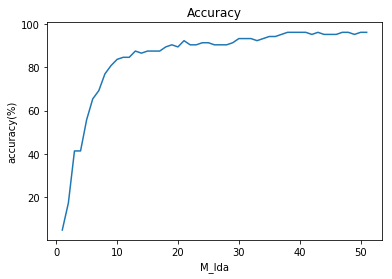

In [86]:
acc = np.zeros(51)
pca = PCA(n_components=135) 
pca.fit(x_n1)
x_p1 = pca.transform(x_n1)   # training 
x_p2 = pca.transform(x_n2)   #test
for i,M_lda in enumerate(range(1,52)):    
    lda = LDA(n_components= M_lda)
    x_l1 = lda.fit_transform(x_p1, y_train)
    x_l2 = lda.transform(x_p2)
    #NN classification
    y_pre = NN_classification(x_l1,x_l2,y_train) #test
    acc[i] =  accuracy_score(y_test,y_pre)*100
print(np.where(acc == np.max(acc)))
plt.plot(range(1,52),acc)
plt.ylabel('accuracy(%)')
plt.xlabel('M_lda')
plt.title('Accuracy')
plt.show()

2.PCA-LDA Ensemble

Randon sampling on training data (Bagging)

In [13]:
n_estimators = 100
sample_num = 290
M_pca = 135
M_lda = 40
y_pre1 = np.zeros((len(y_test),52))
y_pre2 = np.zeros((len(y_test),n_estimators))
acc = 0
x_scaler = StandardScaler()
x_n1 = x_scaler.fit_transform(x_train)
x_n2 = x_scaler.fit_transform(x_test)
pca = PCA(n_components=M_pca) 
pca.fit(x_n1)
x_p1 = pca.transform(x_n1)   
x_p2 = pca.transform(x_n2)
for i in range(n_estimators): 
    s = random.sample(range(x_train.shape[0]), sample_num)    
    #LDA
    lda = LDA(n_components= M_lda)
    lda.fit(x_p1[s,:],y_train[s])
    y_pre1 += lda.predict_proba(x_p2)
    y_pre2[:,i] = lda.predict(x_p2)
    acc += accuracy_score(y_test,y_pre2[:,i])
acc/=n_estimators
y_out1 = np.argmax(y_pre1 ,axis = 1)+1
y_out2 = vote(y_pre2.astype(np.int64))
acc_1  = accuracy_score(y_test,y_out1)
acc_2 = accuracy_score(y_test,y_out2)
print('average accuracy of single model:',acc)
print('accuracy of sum:',acc_1)
print('accuracy of majority vote:',acc_2)

D:\anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
D:\anaconda\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


average accuracy of single model: 0.8666346153846156
accuracy of sum: 0.9326923076923077
accuracy of majority vote: 0.9423076923076923


Randon sampling in feature space

In [23]:
#sum
n_estimators = 100
M0 = 50
M1 = 200
M_lda = 40
y_pre1 = np.zeros((len(y_test),52))
y_pre2 = np.zeros((len(y_test),n_estimators))
acc = 0#average base model accuracy
x_scaler = StandardScaler()
x_n1 = x_scaler.fit_transform(x_train)
x_n2 = x_scaler.fit_transform(x_test)
pca = PCA(n_components=x_train.shape[0]-1) 
pca.fit(x_n1)
x_p1 = pca.transform(x_n1)   
x_p2 = pca.transform(x_n2)
for i in range(n_estimators):     
    s = random.sample(range(M0,x_train.shape[0]-1), M1)
    index = [x for x in range(M0)]+s
    #LDA
    lda = LDA(n_components= M_lda)
    lda.fit(x_p1[:,index], y_train)
    y_pre1 += lda.predict_proba(x_p2[:,index])
    y_pre2[:,i] = lda.predict(x_p2[:,index])
    acc += accuracy_score(y_test,y_pre2[:,i])
acc/=n_estimators
y_out1 = np.argmax(y_pre1 ,axis = 1)+1
y_out2 = vote(y_pre2.astype(np.int64))
acc_1  = accuracy_score(y_test,y_out1)
acc_2 = accuracy_score(y_test,y_out2)
print('average accuracy of single model:',acc)
print('accuracy of sum:',acc_1)
print('accuracy of majority vote:',acc_2)

D:\anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
D:\anaconda\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


average accuracy of single model: 0.9253846153846151
accuracy of sum: 0.9903846153846154
accuracy of majority vote: 0.9903846153846154


<Figure size 720x720 with 0 Axes>

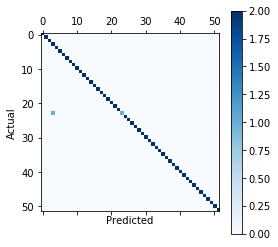

In [24]:
cm = confusion_matrix(y_test,y_out1)
plt.figure(figsize=(10,10))
#plot_confusion_matrix(cm)
plt.matshow(cm, cmap = 'Blues')
plt.colorbar()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
for i in range(len(y_test)):
    if y_test[i] != y_out1[i]:
        

true: [[6, 24, 4, array([4.])]]
predict : [[6, 24, 4, array([4.])]]


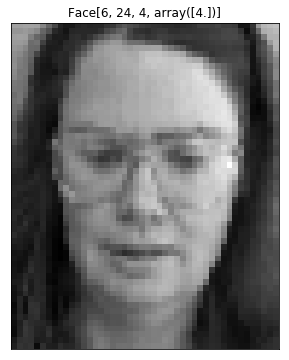

In [32]:
#all failure samples
badcase = [[i,y_test[i],y_out1[i],y_out2[i]] for i in range(len(y_test)) if y_test[i] != y_out1[i]] 
print('true:',badcase)
print('predict :',badcase)

plt.figure(figsize=(6,6))
for i in range(0,len(badcase)):
    plt.subplot(1,len(badcase),i+1)
    plt.imshow(np.reshape(normalise(x_test.T[:,i]),
                          (46,56)).T, cmap = 'gist_gray')
    plt.title('Face'+str(badcase[i])), plt.xticks([]), plt.yticks([])

In [17]:
n_estimators = 25
M_lda = 40
y_pre = np.zeros((len(y_test),n_estimators))
x_scaler = StandardScaler()
x_n1 = x_scaler.fit_transform(x_train)
x_n2 = x_scaler.fit_transform(x_test)
pca = PCA(n_components=x_train.shape[0]-1) 
pca.fit(x_n1)
x_p1 = pca.transform(x_n1)   
x_p2 = pca.transform(x_n2)
x = range(30,150,10)
y = range(50,250,10)
acc = np.zeros((len(y),len(x)))
x, y = np.meshgrid(x, y)
for p,M0 in enumerate(range(30,150,10)):
    for q,M1 in enumerate(range(50,250,10)):
        for i in range(n_estimators):     
            s = random.sample(range(M0,x_train.shape[0]-1), M1)
            index = [k for k in range(M0)]+s
            lda = LDA(n_components= M_lda)
            x_l1 = lda.fit_transform(x_p1[:,index], y_train)
            x_l2 = lda.transform(x_p2[:,index])
            y_pre[:,i] = NN_classification(x_l1,x_l2,y_train)
        y_ensemble = vote(y_pre.astype(np.int64))
        acc[q,p]  =accuracy_score(y_test,y_ensemble)
        #print(acc[p,q])

D:\anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
D:\anaconda\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
D:\anaconda\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


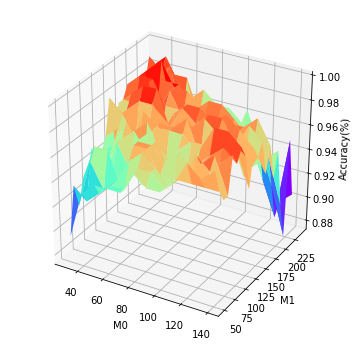

In [18]:
plt.figure(figsize=(6,6))
ax = plt.subplot(111, projection='3d') 
ax.plot_surface(x, y, acc, rstride = 1, cstride = 1,cmap=plt.get_cmap('rainbow'))    
ax.set_zlabel('Accuracy(%)') 
ax.set_ylabel('M1')
ax.set_xlabel('M0')
plt.show()

Bagging+feature random sampling

In [22]:
n_estimators = 100
M0 = 50
M1 = 200
M_lda = 40
sample_num = 290
y_pre1 = np.zeros((len(y_test),52))
y_pre2 = np.zeros((len(y_test),n_estimators))
acc = 0
x_scaler = StandardScaler()
x_n1 = x_scaler.fit_transform(x_train)
x_n2 = x_scaler.fit_transform(x_test)
pca = PCA(n_components=415) 
pca.fit(x_n1)
x_p1 = pca.transform(x_n1)   
x_p2 = pca.transform(x_n2)
for i in range(n_estimators):     
    s1 = random.sample(range(M0,415), M1)
    index = [x for x in range(M0)]+s1
    s2 = random.sample(range(416), sample_num) 
    #LDA
    lda = LDA(n_components= M_lda)
    x = x_p1[:,index]
    x = x[s2,:]
    lda.fit(x, y_train[s2])
    y_pre1 += lda.predict_proba(x_p2[:,index])
    x_l1 = lda.transform(x)
    x_l2 = lda.transform(x_p2[:,index])
    y_pre2[:,i] = NN_classification(x_l1,x_l2,y_train[s2])
    #y_pre2[:,i] = lda.predict(x_p2[:,index])
    acc += accuracy_score(y_test,y_pre2[:,i])
acc/=n_estimators
y_out1 = np.argmax(y_pre1 ,axis = 1)+1
y_out2 = vote(y_pre2.astype(np.int64))
acc_1  = accuracy_score(y_test,y_out1)
acc_2 = accuracy_score(y_test,y_out2)
print('average accuracy of single model:',acc)
print('accuracy of sum:',acc_1)
print('accuracy of majority vote:',acc_2)

D:\anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
D:\anaconda\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
D:\anaconda\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


average accuracy of single model: 0.31663461538461535
accuracy of sum: 0.9519230769230769
accuracy of majority vote: 0.9519230769230769


In [20]:
n_estimators = 200
sample_num = 290
M_pca = 135
M_lda = 40
y_pre1 = np.zeros((len(y_test),52))
y_pre2 = np.zeros((len(y_test),n_estimators))
acc = 0
x_scaler = StandardScaler()
x_n1 = x_scaler.fit_transform(x_train)
x_n2 = x_scaler.fit_transform(x_test)
pca = PCA(n_components=415) 
pca.fit(x_n1)
x_p1 = pca.transform(x_n1)   
x_p2 = pca.transform(x_n2)
for i in range(100): 
    s = random.sample(range(416), sample_num)    
    #LDA
    lda = LDA(n_components= M_lda)
    lda.fit(x_p1[s,:135],y_train[s])
    y_pre1 += lda.predict_proba(x_p2[:,:135])
    y_pre2[:,i] = lda.predict(x_p2[:,:135])
    acc += accuracy_score(y_test,y_pre2[:,i])
for i in range(100,200):     
    s = random.sample(range(M0,415), M1)
    index = [x for x in range(M0)]+s
    #LDA
    lda = LDA(n_components= M_lda)
    lda.fit_transform(x_p1[:,index], y_train)
    y_pre1 += lda.predict_proba(x_p2[:,index])
    y_pre2[:,i] = lda.predict(x_p2[:,index])
    acc += accuracy_score(y_test,y_pre2[:,i])
acc/=n_estimators
y_out1 = np.argmax(y_pre1 ,axis = 1)+1
y_out2 = vote(y_pre2.astype(np.int64))
acc_1  = accuracy_score(y_test,y_out1)
acc_2 = accuracy_score(y_test,y_out2)
print('average accuracy of single model:',acc)
print('accuracy of sum:',acc_1)
print('accuracy of majority vote:',acc_2)

D:\anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
D:\anaconda\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


average accuracy of single model: 0.9013461538461545
accuracy of sum: 0.9711538461538461
accuracy of majority vote: 0.9807692307692307


In [124]:
table = PrettyTable(["Method", "Face Recognition Accuracy(%)"])
table.add_row(["PCA",round(acc1*100,2)])
table.add_row(["PCA-LDA", round(acc4*100,2)])
table.add_row(["Bagging PCA-LDA", round(acc5*100,2)])
table.add_row(["feature sampling PCA-LDA",round(acc6*100,2)])
table.add_row(["Bagging+feature sampling PCA-LDA", round(acc8*100,2)])
table.align["Method"] = "l"
print(table)

+----------------------------------+------------------------------+
| Method                           | Face Recognition Accuracy(%) |
+----------------------------------+------------------------------+
| PCA                              |            71.15             |
| PCA-LDA                          |            97.12             |
| Bagging PCA-LDA                  |            96.15             |
| feature sampling PCA-LDA         |            98.08             |
| Bagging+feature sampling PCA-LDA |            97.12             |
+----------------------------------+------------------------------+
